<a href="https://colab.research.google.com/github/bricaud/ML_tutorial/blob/master/Neural_network_basic_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a neural network
Let us train a neural network with Google Colab

Initialization, importation of the tools for machine learning

In [ ]:
import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.3.0
Hub version: 0.9.0
GPU is available


In [ ]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228818944/228813984 [==============================] - 3s 0us/step


In [ ]:
# Creating the training and validation sets
dataflow_kwargs = dict(interpolation="bilinear",  validation_split=.20, seed=123)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, subset="validation", shuffle=True, **dataflow_kwargs)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Found 3670 files belonging to 5 classes.
Using 2936 files for training.


Let us see what is in the dataset

Data classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


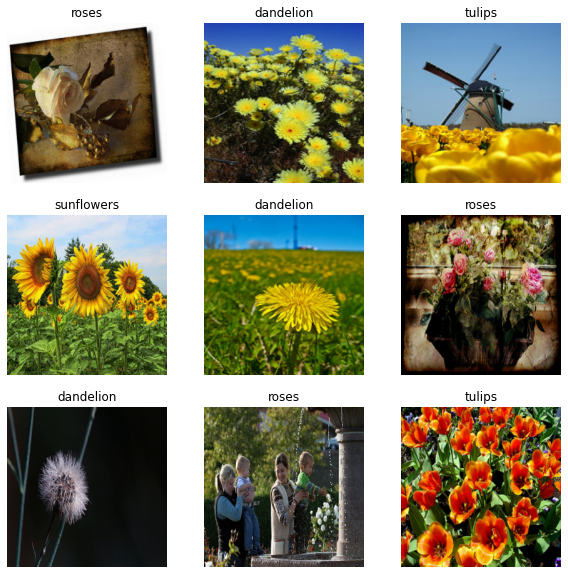

In [ ]:
class_names = train_ds.class_names
print('Data classes:',class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


## Creation of the neural network
* Structure in layers

![texteNeural network. Cyberbotics Ltd. / CC BY-SA (https://creativecommons.org/licenses/by-sa/3.0)](https://upload.wikimedia.org/wikipedia/commons/2/28/Artificial_neural_network_image_recognition.png)

* Convolutional layers well suited for images
* A loss or cost function is defined for the learning


In [ ]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
hist = model.fit(train_ds, validation_data=valid_ds, epochs=4).history 

Epoch 1/4
92/92 [==============================] - 10s 113ms/step - loss: 1.3860 - accuracy: 0.4278 - val_loss: 1.2601 - val_accuracy: 0.5123
Epoch 2/4
92/92 [==============================] - 10s 108ms/step - loss: 1.0109 - accuracy: 0.6049 - val_loss: 1.0137 - val_accuracy: 0.5886
Epoch 3/4
92/92 [==============================] - 10s 107ms/step - loss: 0.8113 - accuracy: 0.6914 - val_loss: 1.0887 - val_accuracy: 0.5722
Epoch 4/4
92/92 [==============================] - 10s 108ms/step - loss: 0.5892 - accuracy: 0.7800 - val_loss: 1.0818 - val_accuracy: 0.6267


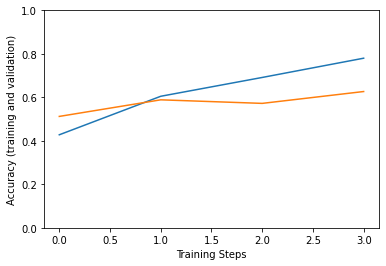

In [ ]:
plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

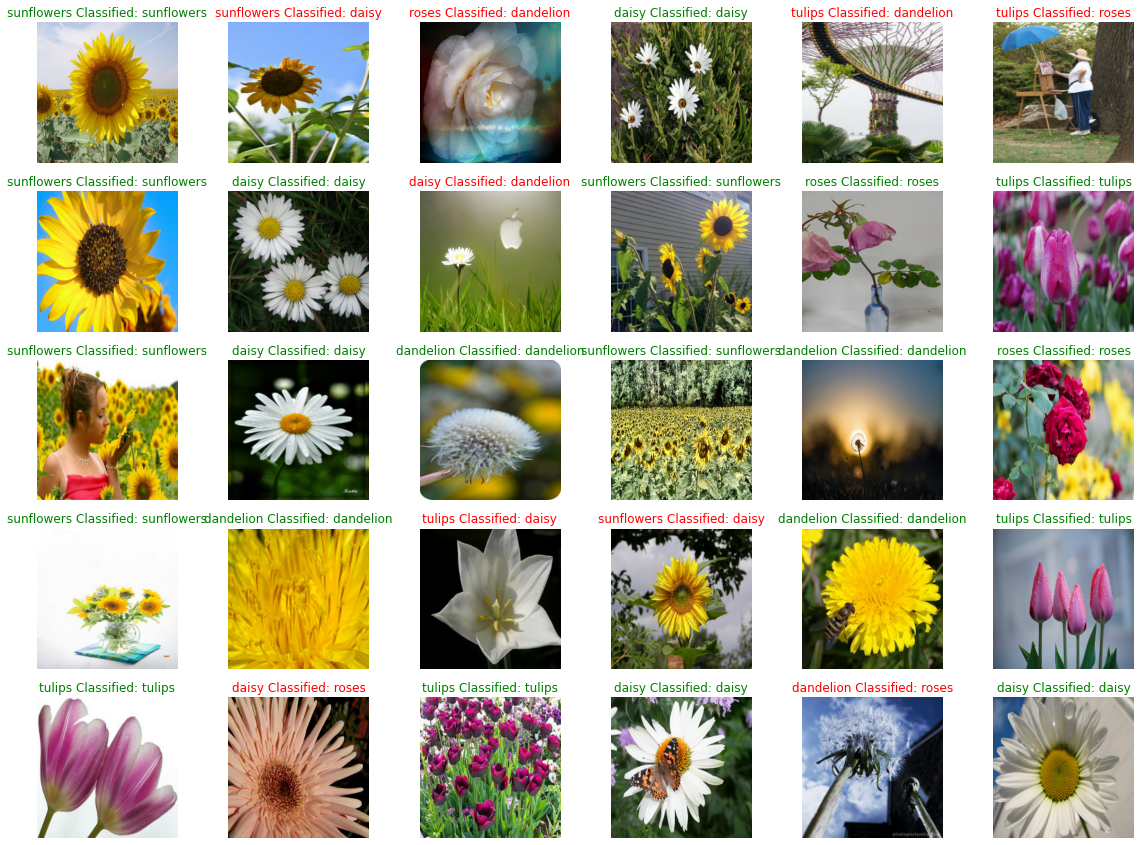

In [ ]:
plt.figure(figsize=(20, 15))
for images, labels in valid_ds.take(1):
  predictions = model.predict(images)
  for i in range(30):
    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    pred_i = class_names[np.argmax(predictions[i])]
    color = "green" if pred_i == class_names[labels[i]] else "red"
    plt.title(class_names[labels[i]]+' Classified: '+pred_i, color=color)
    #plt.title(class_names[np.argmax(pred[i])])
    plt.axis("off")

Let us try a pre-trained model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
module_selection = ("inception_v3", 299) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4 with input size (299, 299)


In [ ]:
IMAGE_SIZE = (train_ds.element_spec[0].shape[1], train_ds.element_spec[0].shape[2])
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    layers.experimental.preprocessing.Rescaling(1./255),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


The inceptionV3 network is described here: https://cloud.google.com/tpu/docs/inception-v3-advanced

In [ ]:
#model.compile(
#  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
#  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
#  metrics=['accuracy'])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:

hist = model.fit(train_ds, epochs=5, validation_data=valid_ds).history

Epoch 1/5
92/92 [==============================] - 16s 168ms/step - loss: 0.7842 - accuracy: 0.7190 - val_loss: 0.4868 - val_accuracy: 0.8324
Epoch 2/5
92/92 [==============================] - 14s 154ms/step - loss: 0.4420 - accuracy: 0.8495 - val_loss: 0.3961 - val_accuracy: 0.8842
Epoch 3/5
92/92 [==============================] - 14s 155ms/step - loss: 0.3610 - accuracy: 0.8770 - val_loss: 0.3780 - val_accuracy: 0.8747
Epoch 4/5
92/92 [==============================] - 14s 154ms/step - loss: 0.3090 - accuracy: 0.8982 - val_loss: 0.3509 - val_accuracy: 0.8965
Epoch 5/5
92/92 [==============================] - 14s 154ms/step - loss: 0.2756 - accuracy: 0.9121 - val_loss: 0.3624 - val_accuracy: 0.8815


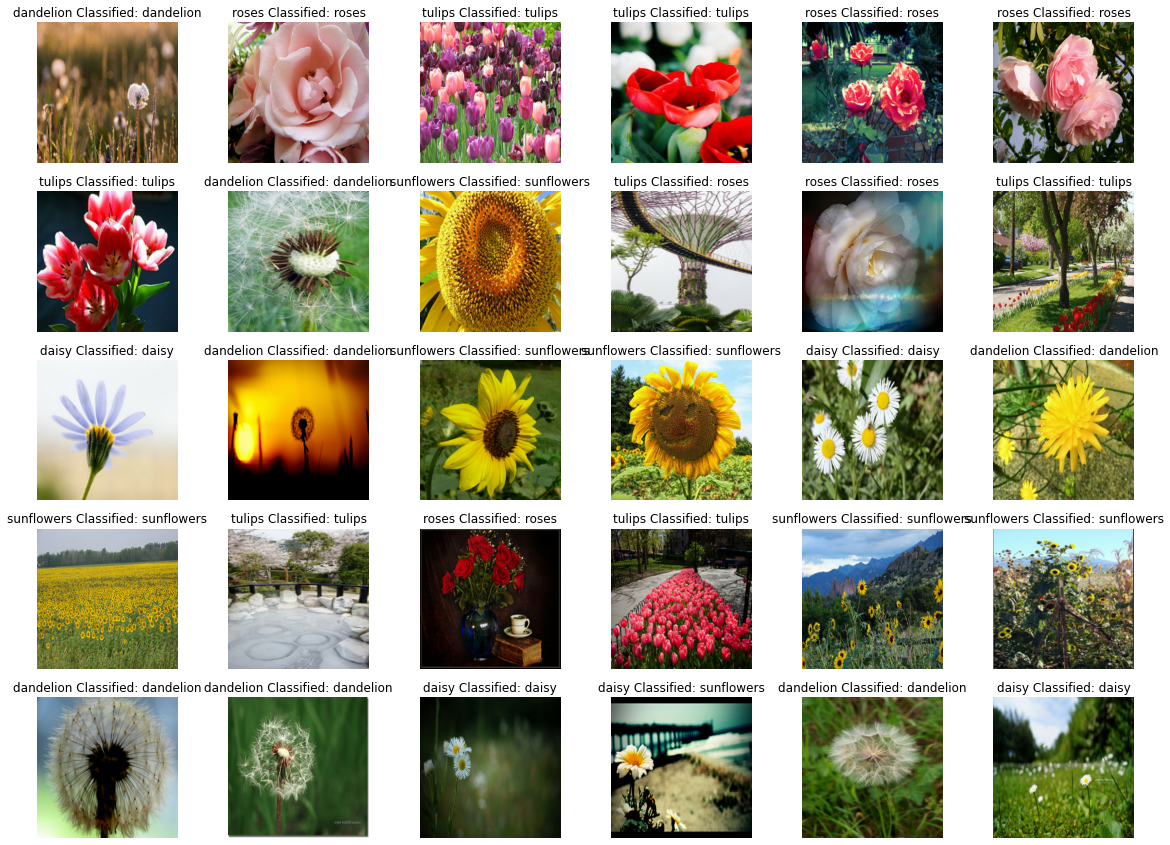

In [ ]:
plt.figure(figsize=(20, 15))
for images, labels in valid_ds.take(1):
  predictions = model.predict(images)
  for i in range(30):
    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    pred_i = class_names[np.argmax(predictions[i])]
    plt.title(class_names[labels[i]]+' Classified: '+pred_i)
    #plt.title(class_names[np.argmax(pred[i])])
    plt.axis("off")